<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Neutron Star Simulation: The "Hydro without Hydro" Test

## Authors: Zach Etienne & Phil Chang
### Formatting improvements courtesy Brandon Clark

## This module sets up initial data for a neutron star on a spherical numerical grid, using the approach [documented in the previous NRPy+ module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb), and then evolves these initial data forward in time. The aim is to reproduce the results from [Baumgarte, Hughes, and Shapiro]( https://arxiv.org/abs/gr-qc/9902024) (which were performed using Cartesian grids); demonstrating that the extrinsic curvature and Hamiltonian constraint violation converge to zero with increasing numerical resolution

**Notebook Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [plot](#convergence) at bottom). Note that convergence in the region causally influenced by the surface of the star will possess lower convergence order due to the sharp drop to zero in $T^{\mu\nu}$.

### NRPy+ Source Code for this module: 

* [TOV/TOV_Solver.py](../edit/TOV/TOV_Solver.py); ([**NRPy+ Tutorial module reviewing mathematical formulation and equations solved**](Tutorial-ADM_Initial_Data-TOV.ipynb)); ([**start-to-finish NRPy+ Tutorial module demonstrating that initial data satisfy Hamiltonian constraint**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb)): Tolman-Oppenheimer-Volkoff (TOV) initial data; defines all ADM variables and nonzero $T^{\mu\nu}$ components in Spherical basis.
* [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
* [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

## Introduction:
Here we use NRPy+ to evolve initial data for a [simple polytrope TOV star](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation), keeping the $T^{\mu\nu}$ source terms fixed. As the hydrodynamical fields that go into $T^{\mu\nu}$ are not updated, this is called the "Hydro without Hydro" test.

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration [(**NRPy+ tutorial on NRPy+ Method of Lines algorithm**)](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on TOV initial data**](Tutorial-ADM_Initial_Data-TOV.ipynb)
    * [**NRPy+ tutorial on validating TOV initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb).
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output the Hamiltonian constraint violation 
        * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb).
    1. At each RK time substep, do the following:
        1. Evaluate BSSN RHS expressions 
            * [**NRPy+ tutorial on BSSN right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb)
            * [**NRPy+ tutorial on BSSN gauge condition right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb) 
            * [**NRPy+ tutorial on adding stress-energy source terms to BSSN RHSs**](Tutorial-BSSN_stress_energy_source_terms.ipynb).
        1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
            * [**NRPy+ tutorial on setting up singular, curvilinear boundary conditions**](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)
        1. Enforce constraint on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ 
            * [**NRPy+ tutorial on enforcing $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint**](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
    1. [Step 1.a](#cfl) Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#adm_id_tov): Set up ADM initial data for polytropic TOV Star
    1. [Step 2.a](#tov_interp): Interpolate the TOV data file as needed to set up ADM spacetime quantities in spherical basis (for input into the `Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear` module) and $T^{\mu\nu}$ in the chosen reference metric basis
1. [Step 3](#adm_id_spacetime): Convert ADM spacetime quantity initial data to BSSN-in-curvilinear-coordinates
1. [Step 4](#bssn): Output C code for BSSN spacetime solve
    1. [Step 4.a](#bssnrhs): Set up the BSSN right-hand-side (RHS) expressions, and add the *rescaled* $T^{\mu\nu}$ source terms
    1. [Step 4.b](#hamconstraint): Output C code for Hamiltonian constraint
    1. [Step 4.c](#enforce3metric): Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$
    1. [Step 4.d](#ccodegen): Generate C code kernels for BSSN expressions, in parallel if possible
    1. [Step 4.e](#cparams_rfm_and_domainsize): Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 5](#bc_functs): Set up boundary condition functions for chosen singular, curvilinear coordinate system
1. [Step 6](#mainc): `TOV_Playground.c`: The Main C Code
1. [Step 7](#visualize): Data Visualization Animations
    1. [Step 7.a](#installdownload): Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded
    1. [Step 7.b](#genimages): Generate images for visualization animation
    1. [Step 7.c](#genvideo): Generate visualization animation
1. [Step 8](#convergence): Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero
1. [Step 9](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$


In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import *            # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("BSSN_Hydro_without_Hydro_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter 
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical, 
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"


# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.
# domain_size     = 7.5 # SET BELOW BASED ON TOV STELLAR RADIUS

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
CFL_FACTOR= 0.5      # (GETS OVERWRITTEN WHEN EXECUTED.) In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

# Set the lapse & shift to be consistent with the original Hydro without Hydro paper.
LapseCondition  = "HarmonicSlicing"
ShiftCondition  = "Frozen"

# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code. 
#       As described above the Table of Contents, this is a 3-step process:
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (post_RHS_string, pt 1)
#       3.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method, 
    RHS_string      = """
Ricci_eval(&rfmstruct, &params, RK_INPUT_GFS, auxevol_gfs);
rhs_eval(&rfmstruct, &params, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);""",
    post_RHS_string = """
apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);
enforce_detgammabar_constraint(&rfmstruct, &params,                     RK_OUTPUT_GFS);\n""",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

# Step 4: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesdir,"SIMD/"))

# Step 7: Set the direction=2 (phi) axis to be the symmetry axis; i.e., 
#         axis "2", corresponding to the i2 direction. 
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")

<a id='cfl'></a>

## Step 1.a: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [2]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

<a id='adm_id_tov'></a>

# Step 2: Set up ADM initial data for polytropic TOV Star \[Back to [top](#toc)\]
$$\label{adm_id_tov}$$

As documented [in the TOV Initial Data NRPy+ Tutorial Module](Tutorial-TOV_Initial_Data.ipynb) ([older version here](Tutorial-GRMHD_UnitConversion.ipynb)), we will now set up TOV initial data, storing the densely-sampled result to file (***Courtesy Phil Chang***).

The TOV solver uses an ODE integration routine provided by scipy, so we first make sure that scipy is installed:

In [3]:
!pip install scipy > /dev/null

Next we call the [TOV.TOV_Solver() function](../edit/TOV/TOV_Solver.py) ([NRPy+ Tutorial module](Tutorial-ADM_Initial_Data-TOV.ipynb)) to set up the initial data, using the default parameters for initial data. This function outputs the solution to a file named "outputTOVpolytrope.txt".

In [4]:
############################
# Single polytrope example #
############################
import TOV.Polytropic_EOSs as ppeos

# Set neos = 1 (single polytrope)
neos = 1

# Set rho_poly_tab (not needed for a single polytrope)
rho_poly_tab = []

# Set Gamma_poly_tab
Gamma_poly_tab = [2.0]

# Set K_poly_tab0
K_poly_tab0 = 1. # ZACH NOTES: CHANGED FROM 100.

# Set the eos quantities
eos = ppeos.set_up_EOS_parameters__complete_set_of_input_variables(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)

import TOV.TOV_Solver as TOV
M_TOV, R_Schw_TOV, R_iso_TOV = TOV.TOV_Solver(eos,
                                              outfile="outputTOVpolytrope.txt",
                                              rho_baryon_central=0.129285,
                                              return_M_RSchw_and_Riso = True,
                                              verbose = True)

domain_size = 2.0 * R_iso_TOV

1256 1256 1256 1256 1256 1256
Just generated a TOV star with 
* M        = 1.405030336771405e-01 ,
* R_Schw   = 9.566044579232513e-01 , 
* R_iso    = 8.100085557410308e-01 , 
* M/R_Schw = 1.468768334847266e-01 



<a id='tov_interp'></a>

## Step 2.a: Interpolate the TOV data file as needed to set up ADM spacetime quantities in spherical basis (for input into the `Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear` module) and $T^{\mu\nu}$ in the chosen reference metric basis \[Back to [top](#toc)\]
$$\label{tov_interp}$$

The TOV data file just written stored $\left(r,\rho(r),P(r),M(r),e^{\nu(r)}\right)$, where $\rho(r)$ is the total mass-energy density (cf. $\rho_{\text{baryonic}}$).

**METRIC DATA IN TERMS OF ADM QUANTITIES**

The [TOV line element](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) in *Schwarzschild coordinates* is written (in the $-+++$ form):
$$
ds^2 = - c^2 e^\nu dt^2 + \left(1 - \frac{2GM}{rc^2}\right)^{-1} dr^2 + r^2 d\Omega^2.
$$

In *isotropic coordinates* with $G=c=1$ (i.e., the coordinate system we'd prefer to use), the ($-+++$ form) line element is written:
$$
ds^2 = - e^{\nu} dt^2 + e^{4\phi} \left(d\bar{r}^2 + \bar{r}^2 d\Omega^2\right),
$$
where $\phi$ here is the *conformal factor*.

The ADM 3+1 line element for this diagonal metric in isotropic spherical coordinates is given by:
$$
ds^2 = (-\alpha^2 + \beta_k \beta^k) dt^2 + \gamma_{\bar{r}\bar{r}} d\bar{r}^2 + \gamma_{\theta\theta} d\theta^2+ \gamma_{\phi\phi} d\phi^2,
$$

from which we can immediately read off the ADM quantities:
\begin{align}
\alpha &= e^{\nu(\bar{r})/2} \\
\beta^k &= 0 \\
\gamma_{\bar{r}\bar{r}} &= e^{4\phi}\\
\gamma_{\theta\theta} &= e^{4\phi} \bar{r}^2 \\
\gamma_{\phi\phi} &= e^{4\phi} \bar{r}^2 \sin^2 \theta \\
\end{align}

**STRESS-ENERGY TENSOR $T^{\mu\nu}$**

We will also need the stress-energy tensor $T^{\mu\nu}$. [As discussed here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation), the stress-energy tensor is diagonal:

\begin{align}
T^t_t &= -\rho \\
T^i_j &= P \delta^i_j \\
\text{All other components of }T^\mu_\nu &= 0.
\end{align}

Since $\beta^i=0$ the inverse metric expression simplifies to (Eq. 4.49 in [Gourgoulhon](https://arxiv.org/pdf/gr-qc/0703035.pdf)):
$$
g^{\mu\nu} = \begin{pmatrix} 
-\frac{1}{\alpha^2} & \frac{\beta^i}{\alpha^2} \\
\frac{\beta^i}{\alpha^2} & \gamma^{ij} - \frac{\beta^i\beta^j}{\alpha^2}
\end{pmatrix} =
\begin{pmatrix} 
-\frac{1}{\alpha^2} & 0 \\
0 & \gamma^{ij}
\end{pmatrix},
$$

and since the 3-metric is diagonal we get

\begin{align}
\gamma^{\bar{r}\bar{r}} &= e^{-4\phi}\\
\gamma^{\theta\theta} &= e^{-4\phi}\frac{1}{\bar{r}^2} \\
\gamma^{\phi\phi} &= e^{-4\phi}\frac{1}{\bar{r}^2 \sin^2 \theta}.
\end{align}

Thus raising $T^\mu_\nu$ yields a diagonal $T^{\mu\nu}$

\begin{align}
T^{tt} &= -g^{tt} \rho = \frac{1}{\alpha^2} \rho = e^{-\nu(\bar{r})} \rho \\
T^{\bar{r}\bar{r}} &= g^{\bar{r}\bar{r}} P = \frac{1}{e^{4 \phi}} P \\
T^{\theta\theta} &= g^{\theta\theta} P = \frac{1}{e^{4 \phi}\bar{r}^2} P\\
T^{\phi\phi} &= g^{\phi\phi} P = \frac{1}{e^{4\phi}\bar{r}^2 \sin^2 \theta} P 
\end{align}

In [5]:
thismodule = "HydrowithoutHydro"
rbar,theta,rho,P,expnu,exp4phi = par.Cparameters("REAL",thismodule,
                                                 ["rbar","theta","rho","P","expnu","exp4phi"],1e300)
IDalpha = sp.sqrt(expnu)
gammaSphDD = ixp.zerorank2(DIM=3)
gammaSphDD[0][0] = exp4phi
gammaSphDD[1][1] = exp4phi*rbar**2
gammaSphDD[2][2] = exp4phi*rbar**2*sp.sin(theta)**2

T4SphUU = ixp.zerorank2(DIM=4)
T4SphUU[0][0] = rho/expnu
T4SphUU[1][1] = P/exp4phi
T4SphUU[2][2] = P/(exp4phi*rbar**2)
T4SphUU[3][3] = P/(exp4phi*rbar**2*sp.sin(theta)**2)

In [6]:
expr_list = [IDalpha]
name_list = ["*alpha"]
for i in range(3):
    for j in range(i,3):
        expr_list.append(gammaSphDD[i][j])
        name_list.append("*gammaDD"+str(i)+str(j))

desc = """This function takes as input either (x,y,z) or (r,th,ph) and outputs
all ADM quantities in the Cartesian or Spherical basis, respectively."""
name = "ID_TOV_ADM_quantities"
outCparams = "preindent=1,outCverbose=False,includebraces=False"

outCfunction(
    outfile=os.path.join(Ccodesdir, name + ".h"), desc=desc, name=name,
    params="""  const REAL xyz_or_rthph[3], 

                const ID_inputs other_inputs,

                REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                REAL *alpha,
                REAL *betaU0,REAL *betaU1,REAL *betaU2,
                REAL *BU0,REAL *BU1,REAL *BU2""",
    body="""
      // Set trivial metric quantities:
      *KDD00 = *KDD01 = *KDD02 = 0.0;
      /**/     *KDD11 = *KDD12 = 0.0;
      /**/              *KDD22 = 0.0;
      *betaU0 = *betaU1 = *betaU2 = 0.0;
      *BU0 = *BU1 = *BU2 = 0.0;      
      
      // Next set gamma_{ij} in spherical basis
      const REAL rbar  = xyz_or_rthph[0];
      const REAL theta = xyz_or_rthph[1];
      const REAL phi   = xyz_or_rthph[2];

      REAL rho,rho_baryon,P,M,expnu,exp4phi;
      TOV_interpolate_1D(rbar,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,  
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.rho_baryon_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,
                         &rho,&rho_baryon,&P,&M,&expnu,&exp4phi);\n"""+
    outputC(expr_list,name_list, "returnstring",outCparams),
    opts="DisableCparameters")

Output C function ID_TOV_ADM_quantities() to file BSSN_Hydro_without_Hydro_Ccodes/ID_TOV_ADM_quantities.h


As all input quantities are functions of $r$, we will simply read the solution from file and interpolate it to the values of $r$ needed by the initial data.

1. First we define functions `ID_TOV_ADM_quantities()` and `ID_TOV_TUPMUNU()` that call the [1D TOV interpolator function](../edit/TOV/tov_interp.h) to evaluate the ADM spacetime quantities and $T^{\mu\nu}$, respectively, at any given point $(r,\theta,\phi)$ in the Spherical basis. All quantities are defined as above.
1. Next we will construct the BSSN/ADM source terms $\{S_{ij},S_{i},S,\rho\}$ in the Spherical basis
1. Then we will perform the Jacobian transformation on $\{S_{ij},S_{i},S,\rho\}$ to the desired `(xx0,xx1,xx2)` basis
1. Next we call the *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function to conver the above ADM quantities to the rescaled BSSN quantities in the desired curvilinear coordinate system: [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

$$
{\rm Jac\_dUSph\_dDrfmUD[mu][nu]} = \frac{\partial x^\mu_{\rm Sph}}{\partial x^\nu_{\rm rfm}},
$$

via exact differentiation (courtesy SymPy), and the inverse Jacobian
$$
{\rm Jac\_dUrfm\_dDSphUD[mu][nu]} = \frac{\partial x^\mu_{\rm rfm}}{\partial x^\nu_{\rm Sph}},
$$

using NRPy+'s `generic_matrix_inverter3x3()` function. In terms of these, the transformation of BSSN tensors from Spherical to `"reference_metric::CoordSystem"` coordinates may be written:

$$
T^{\mu\nu}_{\rm rfm} = 
\frac{\partial x^\mu_{\rm rfm}}{\partial x^\delta_{\rm Sph}}
\frac{\partial x^\nu_{\rm rfm}}{\partial x^\sigma_{\rm Sph}} T^{\delta\sigma}_{\rm Sph}
$$

In [7]:
r_th_ph_or_Cart_xyz_oID_xx = []
CoordType_in = "Spherical"
if CoordType_in == "Spherical":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxSph
elif CoordType_in == "Cartesian":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxCart
else:
    print("Error: Can only convert ADM Cartesian or Spherical initial data to BSSN Curvilinear coords.")
    exit(1)

# Next apply Jacobian transformations to convert into the (xx0,xx1,xx2) basis

# rho and S are scalar, so no Jacobian transformations are necessary.

Jac4_dUSphorCart_dDrfmUD = ixp.zerorank2(DIM=4)
Jac4_dUSphorCart_dDrfmUD[0][0] = sp.sympify(1)
for i in range(DIM):
    for j in range(DIM):
        Jac4_dUSphorCart_dDrfmUD[i+1][j+1] = sp.diff(r_th_ph_or_Cart_xyz_oID_xx[i],rfm.xx[j])

Jac4_dUrfm_dDSphorCartUD, dummyDET = ixp.generic_matrix_inverter4x4(Jac4_dUSphorCart_dDrfmUD)

# Perform Jacobian operations on T^{mu nu} and gamma_{ij}
T4UU = ixp.register_gridfunctions_for_single_rank2("AUXEVOL","T4UU","sym01",DIM=4)

IDT4UU = ixp.zerorank2(DIM=4)
for mu in range(4):
    for nu in range(4):
        for delta in range(4):
            for sigma in range(4):
                IDT4UU[mu][nu] += \
                     Jac4_dUrfm_dDSphorCartUD[mu][delta]*Jac4_dUrfm_dDSphorCartUD[nu][sigma]*T4SphUU[delta][sigma]

lhrh_list = []
for mu in range(4):
    for nu in range(mu,4):
        lhrh_list.append(lhrh(lhs=gri.gfaccess("auxevol_gfs","T4UU"+str(mu)+str(nu)),rhs=IDT4UU[mu][nu]))

desc = """This function takes as input either (x,y,z) or (r,th,ph) and outputs
all ADM quantities in the Cartesian or Spherical basis, respectively."""
name = "ID_TOV_TUPMUNU_xx0xx1xx2"
outCparams = "preindent=1,outCverbose=False,includebraces=False"
outCfunction(
    outfile=os.path.join(Ccodesdir, name + ".h"), desc=desc, name=name,
    params="""const paramstruct *restrict params,REAL *restrict xx[3],
              const ID_inputs other_inputs,REAL *restrict auxevol_gfs""",
    body=outputC([rfm.xxSph[0],rfm.xxSph[1],rfm.xxSph[2]],
                 ["const REAL rbar","const REAL theta","const REAL ph"],"returnstring",
                 "CSE_enable=False,includebraces=False")+"""
      REAL rho,rho_baryon,P,M,expnu,exp4phi;
      TOV_interpolate_1D(rbar,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,  
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.rho_baryon_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,
                         &rho,&rho_baryon,&P,&M,&expnu,&exp4phi);\n"""+
    fin.FD_outputC("returnstring",lhrh_list,params="outCverbose=False,includebraces=False").replace("IDX4","IDX4S"),
    loopopts="AllPoints,Read_xxs")

Output C function ID_TOV_TUPMUNU_xx0xx1xx2() to file BSSN_Hydro_without_Hydro_Ccodes/ID_TOV_TUPMUNU_xx0xx1xx2.h


<a id='adm_id_spacetime'></a>

# Step 3: Convert ADM initial data to BSSN-in-curvilinear coordinates \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

This is an automated process, taken care of by [`BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear`](../edit/BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py), and documented [in this tutorial notebook](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [8]:
import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_TOV_ADM_quantities",
                                                               Ccodesdir=Ccodesdir,loopopts="")

Output C function ID_BSSN_lambdas() to file BSSN_Hydro_without_Hydro_Ccodes/ID_BSSN_lambdas.h
Output C function ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs() to file BSSN_Hydro_without_Hydro_Ccodes/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h
Output C function ID_BSSN__ALL_BUT_LAMBDAs() to file BSSN_Hydro_without_Hydro_Ccodes/ID_BSSN__ALL_BUT_LAMBDAs.h


<a id='bssn'></a>

# Step 4: Output C code for BSSN spacetime solve \[Back to [top](#toc)\]
$$\label{bssn}$$

<a id='bssnrhs'></a>

## Step 4.a: Set up the BSSN right-hand-side (RHS) expressions, and add the *rescaled* $T^{\mu\nu}$ source terms \[Back to [top](#toc)\]
$$\label{bssnrhs}$$

`BSSN.BSSN_RHSs()` sets up the RHSs assuming a spacetime vacuum: $T^{\mu\nu}=0$. (This might seem weird, but remember that, for example, *spacetimes containing only single or binary black holes are vacuum spacetimes*.) Here, using the [`BSSN.BSSN_stress_energy_source_terms`](../edit/BSSN/BSSN_stress_energy_source_terms.py) ([**tutorial**](Tutorial-BSSN_stress_energy_source_terms.ipynb)) NRPy+ module, we add the $T^{\mu\nu}$ source terms to these equations.

In [9]:
import time
import BSSN.BSSN_RHSs as rhs
import BSSN.BSSN_gauge_RHSs as gaugerhs
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::LapseEvolutionOption", LapseCondition)
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::ShiftEvolutionOption", ShiftCondition)

print("Generating symbolic expressions for BSSN RHSs...")
start = time.time()
# Enable rfm_precompute infrastructure, which results in 
#   BSSN RHSs that are free of transcendental functions,
#   even in curvilinear coordinates, so long as 
#   ConformalFactor is set to "W" (default).
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

# Evaluate BSSN + BSSN gauge RHSs with rfm_precompute enabled:
import BSSN.BSSN_quantities as Bq
par.set_parval_from_str("BSSN.BSSN_quantities::LeaveRicciSymbolic","True")

rhs.BSSN_RHSs()

import BSSN.BSSN_stress_energy_source_terms as Bsest
Bsest.BSSN_source_terms_for_BSSN_RHSs(T4UU)
rhs.trK_rhs += Bsest.sourceterm_trK_rhs
for i in range(DIM):
    # Needed for Gamma-driving shift RHSs:
    rhs.Lambdabar_rhsU[i] += Bsest.sourceterm_Lambdabar_rhsU[i]
    # Needed for BSSN RHSs:
    rhs.lambda_rhsU[i]    += Bsest.sourceterm_lambda_rhsU[i]
    for j in range(DIM):
        rhs.a_rhsDD[i][j] += Bsest.sourceterm_a_rhsDD[i][j]

gaugerhs.BSSN_gauge_RHSs()

# We use betaU as our upwinding control vector:
Bq.BSSN_basic_tensors()
betaU = Bq.betaU

import BSSN.Enforce_Detgammabar_Constraint as EGC
enforce_detg_constraint_symb_expressions = EGC.Enforce_Detgammabar_Constraint_symb_expressions()

# Next compute Ricci tensor
par.set_parval_from_str("BSSN.BSSN_quantities::LeaveRicciSymbolic","False")
Bq.RicciBar__gammabarDD_dHatD__DGammaUDD__DGammaU()

# Now register the Hamiltonian as a gridfunction.
H = gri.register_gridfunctions("AUX","H")
# Then define the Hamiltonian constraint and output the optimized C code.
import BSSN.BSSN_constraints as bssncon
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)
Bsest.BSSN_source_terms_for_BSSN_constraints(T4UU)
bssncon.H += Bsest.sourceterm_H

# Now that we are finished with all the rfm hatted
#           quantities in generic precomputed functional
#           form, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()
end = time.time()
print("Finished BSSN symbolic expressions in "+str(end-start)+" seconds.")


def BSSN_RHSs():
    print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
    start = time.time()

    # Construct the left-hand sides and right-hand-side expressions for all BSSN RHSs
    lhs_names = [        "alpha",       "cf",       "trK"]
    rhs_exprs = [gaugerhs.alpha_rhs, rhs.cf_rhs, rhs.trK_rhs]
    for i in range(3):
        lhs_names.append(        "betU"+str(i))
        rhs_exprs.append(gaugerhs.bet_rhsU[i])
        lhs_names.append(   "lambdaU"+str(i))
        rhs_exprs.append(rhs.lambda_rhsU[i])        
        lhs_names.append(        "vetU"+str(i))
        rhs_exprs.append(gaugerhs.vet_rhsU[i])
        for j in range(i,3):
            lhs_names.append(   "aDD"+str(i)+str(j))
            rhs_exprs.append(rhs.a_rhsDD[i][j])
            lhs_names.append(   "hDD"+str(i)+str(j))
            rhs_exprs.append(rhs.h_rhsDD[i][j])

    # Sort the lhss list alphabetically, and rhss to match.
    #   This ensures the RHSs are evaluated in the same order 
    #   they're allocated in memory:
    lhs_names,rhs_exprs = [list(x) for x in zip(*sorted(zip(lhs_names,rhs_exprs), key=lambda pair: pair[0]))]

    # Declare the list of lhrh's
    BSSN_evol_rhss = []
    for var in range(len(lhs_names)):
        BSSN_evol_rhss.append(lhrh(lhs=gri.gfaccess("rhs_gfs",lhs_names[var]),rhs=rhs_exprs[var]))

    # Set up the C function for the BSSN RHSs
    desc="Evaluate the BSSN RHSs"
    name="rhs_eval"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params, 
                      const REAL *restrict auxevol_gfs,const REAL *restrict in_gfs,REAL *restrict rhs_gfs""",
        body     = fin.FD_outputC("returnstring",BSSN_evol_rhss, params="outCverbose=False,SIMD_enable=True",
                                  upwindcontrolvec=betaU).replace("IDX4","IDX4S"),
        loopopts = "InteriorPoints,EnableSIMD,Enable_rfm_precompute")
    end = time.time()
    print("Finished BSSN_RHS C codegen in " + str(end - start) + " seconds.")
    
def Ricci():
    print("Generating C code for Ricci tensor in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
    start = time.time()
    desc="Evaluate the Ricci tensor"
    name="Ricci_eval"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params, 
                      const REAL *restrict in_gfs,REAL *restrict auxevol_gfs""",
        body     = fin.FD_outputC("returnstring",
                                  [lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD00"),rhs=Bq.RbarDD[0][0]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD01"),rhs=Bq.RbarDD[0][1]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD02"),rhs=Bq.RbarDD[0][2]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD11"),rhs=Bq.RbarDD[1][1]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD12"),rhs=Bq.RbarDD[1][2]),
                                   lhrh(lhs=gri.gfaccess("auxevol_gfs","RbarDD22"),rhs=Bq.RbarDD[2][2])],
                                   params="outCverbose=False,SIMD_enable=True").replace("IDX4","IDX4S"),
        loopopts = "InteriorPoints,EnableSIMD,Enable_rfm_precompute")
    end = time.time()
    print("Finished Ricci C codegen in " + str(end - start) + " seconds.")

Generating symbolic expressions for BSSN RHSs...
Finished BSSN symbolic expressions in 7.730978727340698 seconds.


<a id='hamconstraint'></a>

## Step 4.b: Output the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{hamconstraint}$$

Next output the C code for evaluating the Hamiltonian constraint [(**Tutorial**)](Tutorial-BSSN_constraints.ipynb). In the absence of numerical error, this constraint should evaluate to zero. However it does not due to numerical (typically truncation and roundoff) error. We will therefore measure the Hamiltonian constraint violation to gauge the accuracy of our simulation, and, ultimately determine whether errors are dominated by numerical finite differencing (truncation) error as expected.

In [10]:
def Hamiltonian():
    start = time.time()
    print("Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.")
    # Set up the C function for the Hamiltonian RHS
    desc="Evaluate the Hamiltonian constraint"
    name="Hamiltonian_constraint"
    outCfunction(
        outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
        params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                      REAL *restrict in_gfs, REAL *restrict auxevol_gfs, REAL *restrict aux_gfs""",
        body     = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs", "H"), rhs=bssncon.H),
                                  params="outCverbose=False").replace("IDX4","IDX4S"),
        loopopts = "InteriorPoints,Enable_rfm_precompute")

    end = time.time()
    print("Finished Hamiltonian C codegen in " + str(end - start) + " seconds.")

<a id='enforce3metric'></a>

## Step 4.c: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint \[Back to [top](#toc)\]
$$\label{enforce3metric}$$

Then enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [11]:
def gammadet():
    start = time.time()
    print("Generating optimized C code for gamma constraint. May take a while, depending on CoordSystem.")

    # Set up the C function for the det(gammahat) = det(gammabar)
    EGC.output_Enforce_Detgammabar_Constraint_Ccode(Ccodesdir,exprs=enforce_detg_constraint_symb_expressions)
    end = time.time()
    print("Finished gamma constraint C codegen in " + str(end - start) + " seconds.")

<a id='ccodegen'></a>

## Step 4.d: Generate C code kernels for BSSN expressions, in parallel if possible \[Back to [top](#toc)\]
$$\label{ccodegen}$$

In [12]:
# Step 1: Create a list of functions we wish to evaluate in parallel
funcs = [BSSN_RHSs,Ricci,Hamiltonian,gammadet]

try:
    if os.name == 'nt':
        # It's a mess to get working in Windows, so we don't bother. :/
        #  https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
        raise Exception("Parallel codegen currently not available in Windows")
    # Step 1.a: Import the multiprocessing module.
    import multiprocessing

    # Step 1.b: Define master function for parallelization.
    #           Note that lambdifying this doesn't work in Python 3
    def master_func(arg):
        funcs[arg]()

    # Step 1.c: Evaluate list of functions in parallel if possible;
    #           otherwise fallback to serial evaluation:
    pool = multiprocessing.Pool()
    pool.map(master_func,range(len(funcs)))
except:
    # Steps 1.b-1.c, alternate: As fallback, evaluate functions in serial.
    for func in funcs:
        func()

Generating C code for BSSN RHSs in Spherical coordinates.
Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.
Generating C code for Ricci tensor in Spherical coordinates.
Generating optimized C code for gamma constraint. May take a while, depending on CoordSystem.
Output C function enforce_detgammabar_constraint() to file BSSN_Hydro_without_Hydro_Ccodes/enforce_detgammabar_constraint.h
Finished gamma constraint C codegen in 0.18254971504211426 seconds.
Output C function Hamiltonian_constraint() to file BSSN_Hydro_without_Hydro_Ccodes/Hamiltonian_constraint.h
Finished Hamiltonian C codegen in 11.27468752861023 seconds.
Output C function rhs_eval() to file BSSN_Hydro_without_Hydro_Ccodes/rhs_eval.h
Finished BSSN_RHS C codegen in 20.47813129425049 seconds.
Output C function Ricci_eval() to file BSSN_Hydro_without_Hydro_Ccodes/Ricci_eval.h
Finished Ricci C codegen in 47.089542388916016 seconds.


<a id='cparams_rfm_and_domainsize'></a>

## Step 4.e: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [13]:
# Step 3.d.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Step 3.d.ii: Set free_parameters.h
# Output to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above. 
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Step 1.c.ii: Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)

# Step 1.c.iii: Generate xxCart.h, which contains xxCart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
rfm.xxCart_h("xxCart","./set_Cparameters.h",os.path.join(Ccodesdir,"xxCart.h"))

# Step 1.c.iv: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='bc_functs'></a>

# Step 5: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [14]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"))

Wrote to file "BSSN_Hydro_without_Hydro_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved gridfunction "aDD00" has parity type 4.
Evolved gridfunction "aDD01" has parity type 5.
Evolved gridfunction "aDD02" has parity type 6.
Evolved gridfunction "aDD11" has parity type 7.
Evolved gridfunction "aDD12" has parity type 8.
Evolved gridfunction "aDD22" has parity type 9.
Evolved gridfunction "alpha" has parity type 0.
Evolved gridfunction "betU0" has parity type 1.
Evolved gridfunction "betU1" has parity type 2.
Evolved gridfunction "betU2" has parity type 3.
Evolved gridfunction "cf" has parity type 0.
Evolved gridfunction "hDD00" has parity type 4.
Evolved gridfunction "hDD01" has parity type 5.
Evolved gridfunction "hDD02" has parity type 6.
Evolved gridfunction "hDD11" has parity type 7.
Evolved gridfunction "hDD12" has parity type 8.
Evolved gridfunction "hDD22" has parity type 9.
Evolved gridfunction "lambdaU0" has parity type 1.
Evolved gridfunction "lamb

<a id='mainc'></a>

# Step 6: `Hydro_without_Hydro_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$


In [15]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(os.path.join(Ccodesdir,"Hydro_without_Hydro_Playground_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
REAL CFL_FACTOR = """+str(CFL_FACTOR)+"""; // Set the CFL Factor. Can be overwritten at command line.
// Part P0.d: Set TOV stellar parameters
#define TOV_Mass  """+str(M_TOV)+"""
#define TOV_Riso  """+str(R_iso_TOV)+"\n")

In [16]:
%%writefile $Ccodesdir/Hydro_without_Hydro_Playground.c

// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "Hydro_without_Hydro_Playground_REAL__NGHOSTS__CFL_FACTOR.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "SIMD/SIMD_intrinsics.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif
#define wavespeed 1.0 // Set CFL-based "wavespeed" to 1.0.

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set UUGF and VVGF macros, as well as xxCart()
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Set xxCart(const paramstruct *restrict params, 
//                     REAL *restrict xx[3],
//                     const int i0,const int i1,const int i2, 
//                     REAL xCart[3]),
//           which maps xx->Cartesian via
//    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
#include "xxCart.h"

// Step P5: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3], 
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"
    
// Step P7: Implement the algorithm for upwinding.
//          *NOTE*: This upwinding is backwards from
//          usual upwinding algorithms, because the
//          upwinding control vector in BSSN (the shift)
//          acts like a *negative* velocity.
//#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0

// Step P8: Include function for enforcing detgammabar constraint.
#include "enforce_detgammabar_constraint.h"

// Step P9: Find the CFL-constrained timestep
#include "find_timestep.h"

// Step P4: Declare initial data input struct:
//          stores data from initial data solver,
//          so they can be put on the numerical grid.
typedef struct __ID_inputs {
    REAL Rbar;
    int Rbar_idx;
    int interp_stencil_size;
    int numlines_in_file;
    REAL *r_Schw_arr,*rho_arr,*rho_baryon_arr,*P_arr,*M_arr,*expnu_arr,*exp4phi_arr,*rbar_arr;
} ID_inputs;

// Part P11: Declare all functions for setting up TOV initial data.
/* Routines to interpolate the TOV solution and convert to ADM & T^{munu}: */
#include "../TOV/tov_interp.h"
#include "ID_TOV_ADM_quantities.h"
#include "ID_TOV_TUPMUNU_xx0xx1xx2.h"

/* Next perform the basis conversion and compute all needed BSSN quantities */
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"

// Step P10: Declare function necessary for setting up the initial data.
// Step P10.a: Define BSSN_ID() for BrillLindquist initial data

// Step P10.b: Set the generic driver function for setting up BSSN initial data
void initial_data(const paramstruct *restrict params,const bc_struct *restrict bcstruct,
                  const rfm_struct *restrict rfmstruct,
                  REAL *restrict xx[3], REAL *restrict auxevol_gfs, REAL *restrict in_gfs) {
#include "set_Cparameters.h"
        // Step 1: Set up TOV initial data
    // Step 1.a: Read TOV initial data from data file
    // Open the data file:
    char filename[100];
    sprintf(filename,"./outputTOVpolytrope.txt");
    FILE *in1Dpolytrope = fopen(filename, "r");
    if (in1Dpolytrope == NULL) {
        fprintf(stderr,"ERROR: could not open file %s\n",filename);
        exit(1);
    }
    // Count the number of lines in the data file:
    int numlines_in_file = count_num_lines_in_file(in1Dpolytrope);
    // Allocate space for all data arrays:
    REAL *r_Schw_arr     = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rho_arr        = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rho_baryon_arr = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *P_arr          = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *M_arr          = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *expnu_arr      = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *exp4phi_arr    = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rbar_arr       = (REAL *)malloc(sizeof(REAL)*numlines_in_file);

    // Read from the data file, filling in arrays
    // read_datafile__set_arrays() may be found in TOV/tov_interp.h
    if(read_datafile__set_arrays(in1Dpolytrope, r_Schw_arr,rho_arr,rho_baryon_arr,P_arr,M_arr,expnu_arr,exp4phi_arr,rbar_arr) == 1) {
        fprintf(stderr,"ERROR WHEN READING FILE %s!\n",filename);
        exit(1);
    }
    fclose(in1Dpolytrope);
    REAL Rbar = -100;
    int Rbar_idx = -100;
    for(int i=1;i<numlines_in_file;i++) {
        if(rho_arr[i-1]>0 && rho_arr[i]==0) { Rbar = rbar_arr[i-1]; Rbar_idx = i-1; }
    }
    if(Rbar<0) {
        fprintf(stderr,"Error: could not find rbar=Rbar from data file.\n");
        exit(1);
    }
    
    ID_inputs TOV_in;
    TOV_in.Rbar = Rbar;
    TOV_in.Rbar_idx = Rbar_idx;
    
    const int interp_stencil_size = 12;
    TOV_in.interp_stencil_size = interp_stencil_size;
    TOV_in.numlines_in_file = numlines_in_file;
    
    TOV_in.r_Schw_arr     = r_Schw_arr;
    TOV_in.rho_arr        = rho_arr;
    TOV_in.rho_baryon_arr = rho_baryon_arr;
    TOV_in.P_arr          = P_arr;
    TOV_in.M_arr          = M_arr;
    TOV_in.expnu_arr      = expnu_arr;
    TOV_in.exp4phi_arr    = exp4phi_arr;
    TOV_in.rbar_arr       = rbar_arr;
    /* END TOV INPUT ROUTINE */
    

    // Step 1.b: Interpolate data from data file to set BSSN gridfunctions
    ID_BSSN__ALL_BUT_LAMBDAs(params,xx,TOV_in, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammabar_constraint(rfmstruct, params,                   in_gfs);
    ID_BSSN_lambdas(params, xx, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammabar_constraint(rfmstruct, params,                   in_gfs);
    
    ID_TOV_TUPMUNU_xx0xx1xx2(params,xx,TOV_in,auxevol_gfs);

    free(rbar_arr);
    free(rho_arr);
    free(rho_baryon_arr);
    free(P_arr);
    free(M_arr);
    free(expnu_arr);
}

// Step P11: Declare function for evaluating Hamiltonian constraint (diagnostic)
#include "Hamiltonian_constraint.h"    

// Step P12: Declare rhs_eval function, which evaluates BSSN RHSs
#include "rhs_eval.h"

// Step P13: Declare Ricci_eval function, which evaluates Ricci tensor
#include "Ricci_eval.h"

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of 
//         Lines timestepping algorithm, and output periodic simulation diagnostics 
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using 
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian 
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"
    
    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[4],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults 
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }
    
    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0h: Time coordinate parameters
    const REAL t_final =  1.8*TOV_Mass; /* Final time is set so that at t=t_final, 
                                         * data at the origin have not been corrupted 
                                         * by the approximate outer boundary condition */
    
    // Step 0i: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(&params, xx);
    //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time. 
                                             // Add 0.5 to account for C rounding down 
                                             // typecasts to integers.
    int output_every_N = (int)((REAL)N_final/800.0);
    if(output_every_N == 0) output_every_N = 1;

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate 
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }
    
    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    
    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data to an exact solution
    initial_data(&params,&bcstruct, &rfmstruct, xx, auxevol_gfs, y_n_gfs);

    // Step 1b: Apply boundary conditions, as initial data 
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS,evol_gf_parity, y_n_gfs);
    enforce_detgammabar_constraint(&rfmstruct, &params, y_n_gfs);

    // Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
    // http://www.cplusplus.com/reference/ctime/time/
    time_t start_timer,end_timer;
    time(&start_timer); // Resolution of one second...
#endif
    
    // Step 3: Integrate the initial data forward in time using the chosen RK-like Method of 
    //         Lines timestepping algorithm, and output periodic simulation diagnostics 
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.

        // Step 3.a: Output 2D data file periodically, for visualization
        if(n%100 == 0) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs,auxevol_gfs, diagnostic_output_gfs);

            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
            FILE *out2D = fopen(filename, "w");
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS, 
                        NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS, 
                        NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
                const int idx = IDX3S(i0,i1,i2);
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
                xxCart(&params,xx,i0,i1,i2,xCart);
                fprintf(out2D,"%e %e %e %e\n",
                        xCart[1]/TOV_Mass,xCart[2]/TOV_Mass,
                        y_n_gfs[IDX4ptS(CFGF,idx)],log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
            }
            fclose(out2D);
        }

        // Step 3.b: Step forward one timestep (t -> t+dt) in time using 
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"

        // Step 3.c: If t=t_final, output conformal factor & Hamiltonian 
        //           constraint violation to 2D data file
        if(n==N_final-1) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs,auxevol_gfs, diagnostic_output_gfs);
            char filename[100];
            sprintf(filename,"out%d.txt",Nxx[0]);
            FILE *out2D = fopen(filename, "w");
            const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
            const int i1mid=Nxx_plus_2NGHOSTS1/2;
            const int i2mid=Nxx_plus_2NGHOSTS2/2;
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS, 
                        NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS, 
                        NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
                xxCart(&params,xx,i0,i1,i2,xCart);
                int idx = IDX3S(i0,i1,i2);
                fprintf(out2D,"%e %e %e %e\n",xCart[1]/TOV_Mass,xCart[2]/TOV_Mass, y_n_gfs[IDX4ptS(CFGF,idx)],
                        log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
            }
            fclose(out2D);
        }
        // Step 3.d: Progress indicator printing to stderr

        // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
        clock_gettime(CLOCK_REALTIME, &end);
        const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
        time(&end_timer); // Resolution of one second...
        REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
        const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

        const int iterations_remaining = N_final - n;
        const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

        const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
        const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

        // Step 3.d.ii: Output simulation progress to stderr
        if(n % 10 == 0) {
            fprintf(stderr,"%c[2K", 27); // Clear the line
            fprintf(stderr,"It: %d t/M=%.2f dt/M=%.2e | %.1f%%; ETA %.0f s | t/M/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
                   n, n * (double)dt/TOV_Mass, (double)dt/TOV_Mass, (double)(100.0 * (REAL)n / (REAL)N_final),
                   (double)time_remaining_in_mins*60, (double)(dt/TOV_Mass * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
            fflush(stderr); // Flush the stderr buffer
        } // End progress indicator if(n % 10 == 0)
    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.
    
    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(auxevol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing BSSN_Hydro_without_Hydro_Ccodes//Hydro_without_Hydro_Playground.c


In [17]:
import cmdline_helper as cmd

print("Now compiling, should take ~20 seconds...\n")
start = time.time()
cmd.C_compile(os.path.join(Ccodesdir,"Hydro_without_Hydro_Playground.c"), "Hydro_without_Hydro_Playground")
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n")

cmd.delete_existing_files("out96*.txt")
cmd.delete_existing_files("out96-00*.txt.png")

print("Now running, should take ~10 seconds...\n")
start = time.time()
cmd.Execute("Hydro_without_Hydro_Playground", "96 16 2 "+str(CFL_FACTOR),"out96.txt")
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n")

Now compiling, should take ~20 seconds...

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native -funroll-loops BSSN_Hydro_without_Hydro_Ccodes/Hydro_without_Hydro_Playground.c -o Hydro_without_Hydro_Playground -lm`...
Finished executing in 9.43098521232605 seconds.
Finished compilation.
Finished in 9.44281268119812 seconds.

Now running, should take ~10 seconds...

Executing `taskset -c 0,1,2,3,4,5 ./Hydro_without_Hydro_Playground 96 16 2 0.5`...
It: 300 t/M=1.77 dt/M=5.90e-03 | 98.4%; ETA 0 s | t/M/h 1426.97 | gp/s 8.26e+05
Finished executing in 4.623614072799683 seconds.
Finished in 4.632869005203247 seconds.



<a id='visualize'></a>

# Step 7: Data Visualization Animations \[Back to [top](#toc)\]
$$\label{visualize}$$ 

<a id='installdownload'></a>

## Step 7.a: Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded \[Back to [top](#toc)\]
$$\label{installdownload}$$ 

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or (if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`).

In [18]:
print("Ignore any warnings or errors from the following command:")
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget http://astro.phys.wvu.edu/zetienne/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

Ignore any warnings or errors from the following command:


<a id='genimages'></a>

## Step 7.b: Generate images for visualization animation \[Back to [top](#toc)\]
$$\label{genimages}$$ 

Here we loop through the data files output by the executable compiled and run in [the previous step](#mainc), generating a [png](https://en.wikipedia.org/wiki/Portable_Network_Graphics) image for each data file.

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [19]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob('out96-00*.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=7.5
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

N_interp_pts  = 300
N_interp_ptsj = 300j

for filename in file_list:
    fig = plt.figure()
    x,y,other,Ham = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = Ham
    plotdescription = "Numerical Soln."
    plt.title("Single Neutron Star (Ham. constraint)")
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:N_interp_ptsj, pl_ymin:pl_ymax:N_interp_ptsj]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(grid, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    #plt.pcolormesh(grid_y,grid_x, grid, vmin=-8, vmax=0) # Set colorbar range from -8 to 0
    ax = plt.colorbar()
    plt.clim(-9, -2)
    ax.set_label(plotdescription)
    savefig(filename+".png",dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

<a id='genvideo'></a>

## Step 7.c: Generate visualization animation \[Back to [top](#toc)\]
$$\label{genvideo}$$ 

In the following step, [ffmpeg](http://ffmpeg.org) is used to generate an [mp4](https://en.wikipedia.org/wiki/MPEG-4) video file, which can be played directly from this Jupyter notebook.

In [20]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('SingleNS.mp4', fps=5,dpi=150)

In [21]:
## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [22]:
%%HTML
<video width="480" height="360" controls>
  <source src="SingleNS.mp4" type="video/mp4">
</video>

<a id='convergence'></a>

# Step 8: Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero \[Back to [top](#toc)\]
$$\label{convergence}$$

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

First, let's take a look at the numerical error on the x-y plane at a given numerical resolution, plotting $\log_{10}|H|$, where $H$ is the Hamiltonian constraint violation:

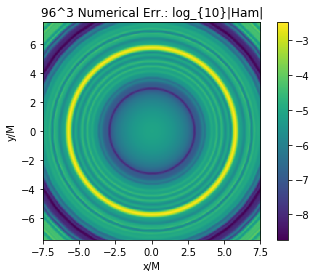

In [23]:
grid96 = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next, we set up the same initial data but on a lower-resolution, $48\times 8\times 2$ grid (axisymmetric in the $\phi$ direction). Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96\times 16\times 2$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected, *except* in the region causally influenced by the star's surface at $\bar{r}=\bar{R}\approx 0.8$ where the stress-energy tensor $T^{\mu\nu}$ sharply drops to zero.

In [24]:
cmd.delete_existing_files("out48*.txt")
cmd.delete_existing_files("out48-00*.txt.png")

print("Now running, should take ~10 seconds...\n")
start = time.time()
cmd.Execute("Hydro_without_Hydro_Playground", "48 8 2 "+str(CFL_FACTOR), "out48.txt")
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

Now running, should take ~10 seconds...

Executing `taskset -c 0,1,2,3,4,5 ./Hydro_without_Hydro_Playground 48 8 2 0.5`...
It: 70 t/M=1.65 dt/M=2.36e-02 | 92.1%; ETA 0 s | t/M/h 38167.98 | gp/s 1.38e+06
Finished executing in 0.22043943405151367 seconds.
Finished in 0.24236083030700684 seconds.


<Figure size 432x288 with 0 Axes>

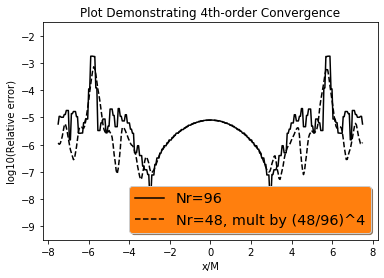

In [25]:
x48,y48,valuesother48,valuesHam48 = np.loadtxt('out48.txt').T #Transposed for easier unpacking
points48 = np.zeros((len(x48), 2))
for i in range(len(x48)):
    points48[i][0] = x48[i]
    points48[i][1] = y48[i]

grid48 = griddata(points48, valuesHam48, (grid_x, grid_y), method='cubic')

griddiff_48_minus_96 = np.zeros((N_interp_pts,N_interp_pts))
griddiff_48_minus_96_1darray = np.zeros(N_interp_pts*N_interp_pts)
gridx_1darray_yeq0 = np.zeros(N_interp_pts)
grid48_1darray_yeq0 = np.zeros(N_interp_pts)
grid96_1darray_yeq0 = np.zeros(N_interp_pts)
count = 0
outarray = []
for i in range(N_interp_pts):
    for j in range(N_interp_pts):
        griddiff_48_minus_96[i][j] = grid48[i][j] - grid96[i][j]
        griddiff_48_minus_96_1darray[count] = griddiff_48_minus_96[i][j]
        if j==N_interp_pts/2-1:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid48_1darray_yeq0[i] = grid48[i][j] + np.log10((48./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid48_1darray_yeq0, 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-9.5,-1.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 9: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [26]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx --log-level='WARN' Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.ipynb to latex
[NbConvertApp] Writing 199846 bytes to Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
